In [1]:
from astroML.datasets import fetch_imaging_sample
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import matplotlib as mpl
from matplotlib import cm

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

from scipy.stats import norm

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.classification import GMMBayes
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

# Section 1: Gussian Mixture Model

## - develop 3 approaches for classifying time series
### the initial approach should extract features from a time series (e.g. using cesium-ml) and apply a GMM classifier (you will need to define how you will classify a continuous function such as period). The classifier should be robust to changes in the phase of the time series

### Read in time-series data

In [2]:
!pip freeze > requirements.yml

In [3]:
def plot_timeseries(df: pd.DataFrame, indx=0 ) -> None:
    '''Plot the generated time series data.
        Args:
            df: Pandas DataFrame with the generated data
            indx: index of the time series to plot
        '''
    df[f'y{indx}' ].plot(style='o')  

    plt.show()

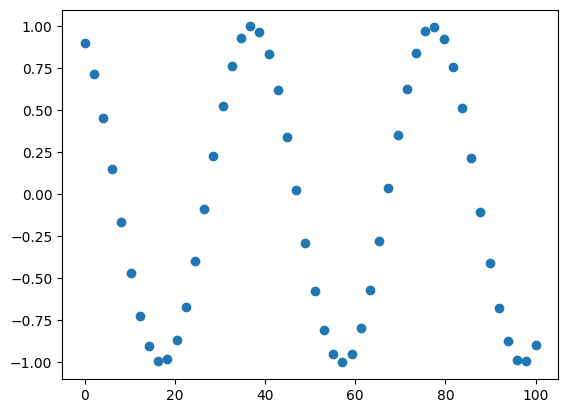

(50, 100000)


,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y99990,y99991,y99992,y99993,y99994,y99995,y99996,y99997,y99998,y99999
0.000000,-0.987242,-0.735776,-0.835780,0.368300,0.993337,0.607363,0.991060,0.913201,0.988297,-0.428671,...,-0.952394,-0.604454,-0.980924,-0.895995,0.947058,0.995710,0.072077,0.894138,-0.717289,-0.824622
2.040816,-0.886773,-0.484893,-0.966216,0.056579,0.906416,0.826751,0.982612,0.738269,0.986016,-0.122144,...,-0.999942,-0.322633,-0.869696,-0.710421,0.797642,0.915826,0.382694,0.707484,-0.461188,-0.960864
4.081633,-0.695953,-0.184606,-0.998207,-0.260906,0.727141,0.961903,0.874048,0.488116,0.883272,0.196827,...,-0.945608,-0.007939,-0.669857,-0.452464,0.566956,0.742629,0.654319,0.448745,-0.158096,-0.999205
6.122449,-0.434223,0.134491,-0.928491,-0.551809,0.473780,0.999047,0.676428,0.188229,0.690533,0.495744,...,-0.794927,0.307564,-0.401767,-0.148405,0.278503,0.493768,0.859276,0.144284,0.161103,-0.935738
8.163265,-0.128251,0.439885,-0.764173,-0.786488,0.172146,0.934401,0.409888,-0.130836,0.427436,0.744150,...,-0.563253,0.591730,-0.092741,0.170774,-0.038327,0.194597,0.976682,-0.174877,0.463888,-0.776931


In [13]:
# df_A = pd.read_csv('/home/jovyan/COURSE_MATERIALS/lectures/data/fieldA.csv')
ts_single_freq_df = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_single_frequency.feather')
ts_single_freq_df.head()
plot_timeseries(ts_single_freq_df, indx=10000)
print(ts_single_freq_df.shape)
ts_single_freq_df.head()

In [1]:
# # df_A = pd.read_csv('/home/jovyan/COURSE_MATERIALS/lectures/data/fieldA.csv')
# df_A = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_multiple_frequency.feather')
# df_A.head()
# plot_timeseries(df_A, indx=10)

In [9]:
# # df_A = pd.read_csv('/home/jovyan/COURSE_MATERIALS/lectures/data/fieldA.csv')
# df_A = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_multiple_frequency_sampled.feather')
# df_A.head()
# plot_timeseries(df_A, indx=10)

### Read in periods from Tobin

### Part 1: Using cesium-ml to extract features

In [5]:
from cesium import featurize

features_to_use = [
    "amplitude",
    "percent_beyond_1_std",
    "maximum",
    "max_slope",
    "median",
    "median_absolute_deviation",
    "percent_close_to_median",
    "minimum",
    "skew",
    "std",
    "weighted_average",
]
fset_cesium = featurize.featurize_time_series(
    times=np.array(ts_single_freq_df.index),
    values=np.array(ts_single_freq_df['y10']),
    errors=None,
    features_to_use=features_to_use,
)
# print(fset_cesium.head())
fset_cesium.head()

feature,amplitude,percent_beyond_1_std,maximum,max_slope,median,median_absolute_deviation,percent_close_to_median,minimum,skew,std,weighted_average
channel,0,0,0,0,0,0,0,0,0,0,0
0,0.999236,0.5,0.99852,0.156401,0.03205,0.717286,0.12,-0.999953,-0.034345,0.713327,0.022469


### Gussian Mixture Model Bayes

#### Data Split

In [11]:
# Data Split
X = np.array(ts_single_freq_df[['y0', 'y1']])
y = np.array(ts_single_freq_df['y99999'])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)
print(f'Training set N={len(X_train)}, Shape:{X_train.shape}\nTesting set N={len(X_test)}, Shape:{X_test.shape} \nValidation set N={len(X_valid)}, Shape:{X_valid.shape}') 

Training set N=40, Shape:(40, 2)
Testing set N=5, Shape:(5, 2) 
Validation set N=5, Shape:(5, 2)


In [9]:
y_train

array([ 0.49751745,  0.97663851,  0.85917115, -0.99970633, -0.99920496,
        0.19882993, -0.55207322,  0.9960997 , -0.9859033 , -0.77693102,
        0.85106206,  0.36800576, -0.12011609,  0.64225301, -0.44091729,
        0.07187357,  0.73499703, -0.30767566,  0.60436039,  0.74551367,
        0.48388763,  0.91755062,  0.97315767,  0.18347564, -0.95641313,
       -0.89018987, -0.81567243,  0.38250529,  0.91121869, -0.42682365,
       -0.53896321, -0.13563041, -0.94114095,  0.82462191, -0.96086393,
        0.99459763, -0.2612124 , -0.69004279, -0.24608125, -0.8829545 ])

In [10]:
X

array([[-9.87241830e-01, -7.35776045e-01],
       [-8.86773469e-01, -4.84893341e-01],
       [-6.95953083e-01, -1.84605580e-01],
       [-4.34223078e-01,  1.34491368e-01],
       [-1.28250732e-01,  4.39885192e-01],
       [ 1.90788889e-01,  7.00459770e-01],
       [ 4.90389316e-01,  8.89665550e-01],
       [ 7.40024708e-01,  9.88224635e-01],
       [ 9.14260088e-01,  9.86094989e-01],
       [ 9.95342873e-01,  8.83493597e-01],
       [ 9.75011660e-01,  6.90874363e-01],
       [ 8.55337966e-01,  4.27862973e-01],
       [ 6.48515165e-01,  1.21257263e-01],
       [ 3.75616122e-01, -1.97703168e-01],
       [ 6.44461135e-02, -4.96519919e-01],
       [-2.53290213e-01, -7.44746997e-01],
       [-5.45219178e-01, -9.17092916e-01],
       [-7.81596576e-01, -9.95997608e-01],
       [-9.38338266e-01, -9.73421592e-01],
       [-9.99474072e-01, -8.51665104e-01],
       [-9.58774959e-01, -6.43133731e-01],
       [-8.20387697e-01, -3.69074423e-01],
       [-5.98412358e-01, -5.74106736e-02],
       [-3.

# Section 2: Convolutional Nural Network

# Section 3: 